### TODAY
* Forward feature selection
* Images, pre-processing, loading
* Data augmentation
* Data Loader
* Build-in datasets

## Forward Feature Selection

### An example without cross validation and with K-Nearest Neighbour as the classifier

1) Initialization: Start with an empty set of selected features: selected_features = [].
Define a performance metric (e.g., accuracy, F1 score) to evaluate the model.

2) Loop for feature selection: For each feature not in selected_features, calculate the performance of the model by adding that feature to the set. Train and evaluate the model with the current set of selected features plus the feature under consideration.
Keep track of the performance obtained for each feature addition.

3) Select the best feature: Choose the feature that resulted in the highest performance metric. Add this feature to the selected_features set.

4) Repeat: Repeat steps 2 and 3 until a predefined stopping condition is met (e.g., reaching a specified number of features or a performance threshold).

5) Final Model: Train a final model using the selected subset of features.


In [ ]:
# Import the needed libraries
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Divide the dataset into train and validation splits
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

#  Feature selection variables
selected_features = []
best_accuracy = 0
best_feature = None
stopping_condition = 5  # Define a stopping condition, for example, the number of features to select is 5.

# Create a list of available features (in this case, the dataset's feature names)
all_features = list(range(X.shape[1]))

while len(selected_features) < stopping_condition:
    for feature in all_features:
        if feature not in selected_features:
           # Train k/NN with the selected features
            current_features = selected_features + [feature]
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_train[:, current_features], y_train)
            y_pred = knn.predict(X_validation[:, current_features])

            # Calculate accuracy
            accuracy = accuracy_score(y_validation, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature

    # Select the best features
    selected_features.append(best_feature)
    print(f"Selected Feature Index: {best_feature}, Validation Accuracy: {best_accuracy}")

# Now, the list 'selected_features' contains the indices of the selected features.

# Train the final model using the subset of selected features.
final_features = selected_features
knn_final = KNeighborsClassifier(n_neighbors=5)
knn_final.fit(X_train[:, final_features], y_train)
print("Final selected features' index: ", np.unique(selected_features))

# In this example, we do not have a test set.
# If we had one, we could use "knn_final.predict(X_test[:, final_features])" to make predictions.

Selected Feature Index: 13, Validation Accuracy: 0.9298245614035088
Selected Feature Index: 0, Validation Accuracy: 0.9385964912280702
Selected Feature Index: 26, Validation Accuracy: 0.956140350877193
Selected Feature Index: 26, Validation Accuracy: 0.956140350877193
Selected Feature Index: 26, Validation Accuracy: 0.956140350877193
Final selected features' index:  [ 0 13 26]


## Alternatively use sklearn feature selection

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

## Image
### What to Import?
* `torch`: Contains all the tools needed to train a network.
* `torchvision`: Contains datasets and other functions.

In [ ]:
# Load the packages
import torch
import torchvision
import PIL.Image as Image  # PIL is Python Imaging Library
from scipy import io  # io for input/output operations
import numpy as np  # Remember that numpy is for Numerical Calculations

In [ ]:
# Download the dataset we will work with: [Flower102 Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)
# Note that we can use bash commands in Colab
# mkdir: creates a new directory
# wget: downloads a file from the web
# tar: extracts files from an archive (unzip)
# rm: removes (deletes) a file


%%bash
mkdir ./flowers102/
wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat -P ./flowers102/
wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat -P ./flowers102/
wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz -P ./flowers102/
tar zxvf ./flowers102/102flowers.tgz -C ./flowers102/
rm ./flowers102/102flowers.tgz

In [ ]:
ls /content/flowers102/

imagelabels.mat  jpg/  setid.mat


In [ ]:
# List the files and directories present in the "flowers102" folder

import os
directory = '/content/flowers102/'
contents = os.listdir(directory)
print(contents)

['jpg', 'imagelabels.mat', 'setid.mat.1', 'imagelabels.mat.1', 'setid.mat', 'setid.mat.2', 'imagelabels.mat.2']


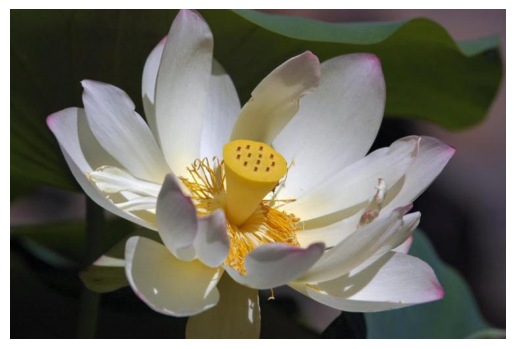

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/flowers102/jpg/image_01907.jpg'
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels
plt.show()


## DATASETS

There are two important classes.

1) ```torch.utils.data.Dataset```: This is used to organize and represent a collection of data samples, including access to labels if present. This class allows the creation of a custom dataset derived from it, requiring the implementation of the following methods (RECAP Inheritance in Python):

```__init__```: This is the constructor.

```__len__```: Returns the number of samples in our dataset and is used by the dataloader.

```__getitem__```: This is called by the Dataloader along with the ```idx``` to retrieve a new sample from the dataset.

2) ```torch.utils.data.DataLoader```: This is an iterable that wraps the Dataset and is used to access the samples.

In other words:

```torch.utils.data.Dataset```: it is used to represent the samples, the corresponding labels (if any), and the transformations applied to them.

```torch.utils.data.DataLoader```: is an iterable wrapped around Dataset and is used to access the samples.


## EXAMPLE: Customization of a dataset and a dataloader


In [ ]:
import glob, os  # Used to access image files in a directory and perform file-related operations
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class FlowersDataset(torch.utils.data.Dataset):

    def __init__(self, root: str):
        self.root = root
        self.split_ids = io.loadmat(os.path.join(root, "setid.mat"))  # To get the dataset split information: training, validation, test
        self.labels = io.loadmat(os.path.join(root, "imagelabels.mat"))["labels"][0]  # To get the class information of the dataset (labels)
        self.image_paths = sorted(glob.glob(os.path.join(self.root, "jpg", "*.jpg")))  # Get a list of image files in the "jpg" folder

    # This function returns the number of images in the dataset
    def __len__(self):
        return len(self.image_paths)

    # This function returns the image and the corresponding label for the specified index in the dataset.
    def __getitem__(self, idx: int):
        label = self.labels[idx]
        img = Image.open(self.image_paths[idx]).convert("RGB")
        return img, label




In [ ]:
dataset = FlowersDataset(root="./flowers102/")

In [ ]:
print(f"Flower102 contains: {len(dataset)} samples")

Flower102 contains: 8189 samples


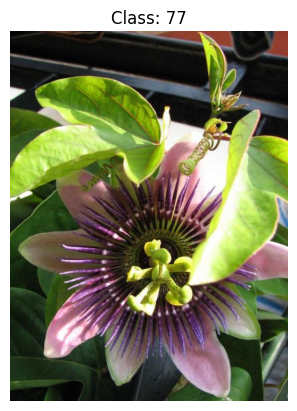

In [ ]:
img, label = dataset.__getitem__(2)

img = np.array(img)
plt.imshow(img)
plt.title(f"Class: {label}")
plt.axis("off")
plt.show()

 ## Pre-processing of data

[ENG]

When loading your data, you always need some preprocessing step.
For images, the basic things to do are:
* resize image: each image will have the same size
* normalize images: each image will be in the same range

To do these we will use the class `torchvision.transforms`



### torchvision.transforms.ToTensor()
* This transformation converts the input image to a PyTorch tensor.
* It also divides each pixel value in the image by 255 to normalize the pixel values to the range [0, 1].
* The resulting tensor has the format channel x height x width (C x H x W), which is suitable for deep learning models.
* The division by 255 is a common normalization step when working with images. In many image formats, pixel values are typically represented as integers in the range [0, 255], where 0 represents black and 255 represents white (in grayscale images).

### Resize
`torchvision.transforms.Resize(size=(H, W))`

## Resize the image to a specific size (H, W).
This transformation ensures that all images have the same dimensions, which is often necessary when working with neural networks, as many architectures require input images to have fixed sizes.


In [ ]:
resize = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Resize(size=(256, 256))
])

In [ ]:
img_resized = resize(img)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
print(f"Original image type {type(img)} --> Processed image type: {type(img_resized)}")
img = np.array(img)
print(f"Original Image size: {img.shape} --> Processed image shape: {img_resized.shape}")
print(f"Original Image range: [{img.min()}, {img.max()}] --> Processed image range:  [{img_resized.min()}, {img_resized.max()}]")

Original image type <class 'numpy.ndarray'> --> Processed image type: <class 'torch.Tensor'>
Original Image size: (667, 500, 3) --> Processed image shape: torch.Size([3, 256, 256])
Original Image range: [0, 255] --> Processed image range:  [0.0, 1.0]


⚠ **Warning**:

The default shape of images is `ch x H x W`, while usually images are represented by `H x W x ch`.
You will need to `permute`, i.e. create a different view of the data, when using different packages.



In [ ]:
img_resized_permuted = img_resized.permute(1, 2, 0)
print(f"Before permutation: {img_resized.shape} --> After permutation:  {img_resized_permuted.shape}")

Before permutation: torch.Size([3, 256, 256]) --> After permutation:  torch.Size([256, 256, 3])


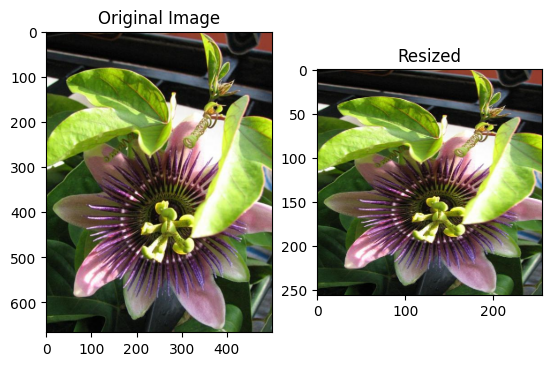

In [ ]:
f = plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(img_resized_permuted)
plt.title("Resized")
plt.show()

### Normalization

`torchvision.transforms.Normalize(mean, std)`: normalizes the image using the formula `image = (image - mean) / std`

Common normalizations for images include:

*   `transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))` normalizing the data in the range [0, 1]
*   `transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))` normalizing the data in the range [-1, +1]
*   `transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))` normalizing using the mean and standard deviation calculated on the training set [ImageNet](https://www.image-net.org/).

PS: ImageNet consists of millions of labeled images belonging to thousands of different categories or classes.

⚠ **Warning**: Always normalize training and test samples in the same way!


In [ ]:
# Normalization
resize_normalize = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(256, 256)),
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

In [ ]:
img_normalized = resize_normalize(img)
print(f"Original Image range: [{img_resized.min()}, {img_resized.max()}] --> Processed image range:  [{img_normalized.min()}, {img_normalized.max()}]")

Original Image range: [0.0, 1.0] --> Processed image range:  [-1.0, 1.0]


## Data Augmentation

* Is a form of regularization
* It refers to “artificially” (syntactically) enlarge the training set
* Is a very powerful and useful technique that can boost the performance

### How to Do It?

To perform data augmentation, we can use transformations from the `torchvision.transforms` module: https://pytorch.org/vision/stable/transforms.html

⚠ **Warning**: Data augmentation should only be applied to *training* samples, not to *validation* or *test* samples.


In [ ]:
T = torchvision.transforms.Compose([
    # Normalization / Resize
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(256, 256)),
    torchvision.transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),  # normalize between [0, 1]


    # Data Aug
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    # This transformation has a 50% probability (p=0.5) of performing a random vertical flip of the image, meaning the image may be flipped vertically.
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # .... the image may be flipped horizontally.
    torchvision.transforms.RandomGrayscale(p=0.3),
    # There is a 30% chance that the image will be transformed to black and white.
    torchvision.transforms.ColorJitter(brightness=0.2, hue=0.4, saturation=0.1),
    # Color jittering on the image
    # brightness=0.2: The brightness of the image can vary by a maximum of 20%.
    # hue=0.4: The hue of the image can vary in a range of up to 0.4 (i.e., +/- 0.2).
    # saturation=0.1: The saturation of the image can vary by a maximum of 10%.


])

In [ ]:
img_transformed = T(img)

In [ ]:
f = plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(img_transformed.permute(1,2,0))
plt.title("Transformed")
plt.show()

Execute `img_transformed = T(img)` multiple times.
Note that due to the random functions, the transformed image may be different each time.


# Dataloader

Dataloader wraps a Dataset instance and allows to efficiently load data from it through multiprocessing.
What happens is that the dataloader will select and index, in the range `[0, len(dataset)]`, and call `dataset.__getitem__(idx)`.

There are more complicated fucntions already implemented for you.
The main options we investigate are:

*   `batch_size`: the number of samples that will be returned by one iteration
*   `shuffle`: whether to shuffle the samples in the dataset or not

⚠ **Warning**: use `shuffle=True` for *training* set and `suffle=False` for the *validation* and *test* set.

In [ ]:
# Let's rewrite our Dataset class, adding the transformations
class FlowersDataset(torch.utils.data.Dataset):

  def __init__(self, root: str):

    self.root = root

    self.split_ids = io.loadmat(os.path.join(root, "setid.mat"))
    self.labels = io.loadmat(os.path.join(root, "imagelabels.mat"))["labels"][0]
    self.image_paths = sorted(glob.glob(os.path.join(self.root, "jpg", "*.jpg")))

    # [New Source Code] Let's define the transformations we want to apply
    self.T = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(size=(256, 256)),
    ])

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx: int):

    label = self.labels[idx]
    img = Image.open(self.image_paths[idx]).convert("RGB")
    img = self.T(img)  # [New Source Code] image pre-processing

    return img, label

In [ ]:
dataset = FlowersDataset(root="./flowers102/")
# The DataLoader provides batches of 8 samples from our dataset, but it maintains the original order of the data.
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=8,
                                        shuffle=False)

In [ ]:
# Create an iterator object from the dataloader, which allows you to iterate through batches of data in the dataloader one at a time
dataloader_iterator = iter(dataloader)

In [ ]:
# next() is a function that retrieves the next element (batch) from dataloader_iterator.
batch = next(dataloader_iterator)

In [ ]:
# In a DataLoader, "batch" is typically a tuple or list of two elements,
# where the first element contains the data (e.g., images)
# and the second element contains the corresponding labels.
batch_images, batch_labels = batch  # extract data from the "batch" variable and assign it to the "batch_images" and "batch_labels" variables.

PyTorch represents batches of images in the format [bs x ch x H x W], where:
* bs: the number of samples in the batch (batch size)
* ch: the number of channels in the image (typically 1 for grayscale or 3 for RGB)
* H: the height of the image
* W: the width of the image


In [ ]:
print(f"Images: {batch_images.shape}")
print(f"Labels: {batch_labels.shape}")

Images: torch.Size([8, 3, 256, 256])
Labels: torch.Size([8])


In [ ]:
# Visualize each image in the batch
for b_idx in range(batch_images.shape[0]):
  img = batch_images[b_idx]
  label = batch_labels[b_idx]
  plt.imshow(img.permute(1,2,0))
  plt.title(f"Class: {label}")
  plt.axis("off")
  plt.show()

## Training loop
When training a model on a dataset, you want to iterate over all the examples and update the model.

In [ ]:
for iter_counter, batch in enumerate(dataloader):
    images, labels = batch
    """
    Here is where we would update our model based on the current training batch.
    We'll see this in the next course.
    For now, we just visualize the images.
    """
    images_vis = torchvision.utils.make_grid(images)  # The "make_grid" function is used to display all images in a batch together.
    print(f"Iteration: {iter_counter}, Images:")
    plt.imshow(images_vis.permute(1, 2, 0))  # Note that we permute "images_vis" and not a single image.
    plt.show()

    if iter_counter >= 10:
        # Exit the loop after the tenth iteration, otherwise it will continue for the entire dataset.
        break

## Built-in Datasets

All built-in datasets are subclasses of `torch.utils.data.Dataset`, meaning they have the `__getitem__` and `__len__` methods implemented. Consequently, they can all be passed to a `torch.utils.data.DataLoader`, which can load multiple samples in parallel using `torch.multiprocessing` workers.

The list of built-in datasets: [https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html).

### We can use them with a single line of code.


In [ ]:
img_size = 256
T = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize(size=(img_size, img_size)),
      ])

In [ ]:
torchflowers = torchvision.datasets.Flowers102(root="./torchvision_flowers102/", # We use the Flowers102 dataset
                                               split="train", # We want to use the training data (try "val" and "test")
                                               download=True, # Download the dataset if it's not already available in the specified directory (root)
                                               transform=T) # We will apply the transformation just defined


In [ ]:
train_dataloader = torch.utils.data.DataLoader(torchflowers,
                                        batch_size=1,
                                        shuffle=True)

In [ ]:
img, label = next(iter(train_dataloader))

In [ ]:
plt.figure()
plt.imshow(img[0].permute(1,2,0))
plt.show()

# Exercise

Aim is to creating your own FlowersDataset.
First download the dataset you will work on using the code:

``` %%bash
mkdir ./flowers102/
wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat -P ./flowers102/
wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat -P ./flowers102/
wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz -P ./flowers102/
tar zxvf ./flowers102/102flowers.tgz -C ./flowers102/
rm ./flowers102/102flowers.tgz
```

You need to use the Dataloader to iterate through the samples of train and test sets and visualize them.
(In this case we omit the validation set for simplicity.)

Remember the ids are in `flowers102/setid.mat`.

You need to apply following:

| **Operation** | **Train** | **Test** |
| --- | --- | --- |
| Normalize and Resize | ✅ | ✅ |
| Data Augmenation | ✅ | ⛔ |
| Shuffle Dataloader | ✅ | ⛔ |


Useful
torchvision transformations can e found in: https://pytorch.org/vision/stable/transforms.html

HINTS:

a) You need to create the dataset class that can handle training and test.

b)	You need to split the data according to the partition (use ```setid.mat```)

c)	```io.loadmat``` is to load all the ids. Recall that the ids in ```setid.mat``` of FlowerDataset 1-indexed.
To train a model you need to subtract “1” from the indexes supplied.
```ids["trnid"][0]``` is for training. ```ids["tstid"][0]``` is for testing.

d)	For training apply any augmentation you want (for example: ```RandomHorizontalFlip```, ```RandomInvert```)

e)	Use batch size 8 to use DataLoader

f)	Notice that you need to separate train and test DataLoaders
